In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

ModuleNotFoundError: No module named 'torch'

In [2]:
#Part 1: Prediction with Hardcoded Model

In [3]:
test_df = pd.read_csv("test.csv")
test_np = test_df.values
test_tensor = torch.from_numpy(test_np).to(torch.float64)

In [4]:
testX_tensor = test_tensor[:,:-1]

In [5]:
testY_tensor = test_tensor[:,-1].reshape(-1,1)

In [6]:
train_df = pd.read_csv("train.csv")
train_np = train_df.values
train_tensor = torch.from_numpy(train_np).to(torch.float64)

In [7]:
trainX_tensor = train_tensor[:,:-1]

In [8]:
trainY_tensor = train_tensor[:,-1].reshape(-1,1)

In [9]:
coef = torch.tensor([
        [0.0040],
        [0.0040],
        [0.0040],
        [0.0040],
        [0.0040],
        [0.0040], # POS_50_59_CP
        [0.0300], # POS_60_69_CP
        [0.0300],
        [0.0300],
        [0.0300]
], dtype=testX_tensor.dtype)
#coef

In [10]:
print("Predicted number of deaths in this tract: ", (testX_tensor[0] @ coef).item())

Predicted number of deaths in this tract:  9.844


In [11]:
#REQUIREMENT
if torch.cuda.is_available():
    print("on GPU")
    testX_tensor.to("cuda")
    testY_tensor.to("cuda")
    trainX_tensor.to("cuda")
    trainY_tensor.to("cuda")
    coef.to("cuda")

In [12]:
#Part 2: R^2 Score

In [13]:
predictedY = testX_tensor @ coef
avg = testY_tensor.sum()/len(testY_tensor)
SStot = ((testY_tensor - avg)**2).sum()

In [14]:
SSreg = ((testY_tensor - predictedY)**2).sum()

In [15]:
improvement = SStot - SSreg
r2_score = improvement/SStot

In [16]:
def r2_score(trueY, predictedY):
    avg = trueY.sum()/len(trueY)
    SStot = ((trueY - avg)**2).sum()
    SSreg = ((trueY - predictedY)**2).sum()
    improvement = SStot - SSreg
    r2_score = improvement/SStot
    return r2_score

In [17]:
r2_score(testY_tensor, predictedY).item()

0.41103503288417204

In [18]:
#Part 3: Optimization

In [19]:
x = torch.tensor(0.0, requires_grad=True)
y = x**2 - 8*x + 19
y

tensor(19., grad_fn=<AddBackward0>)


Optimized value:  3.9950480461120605


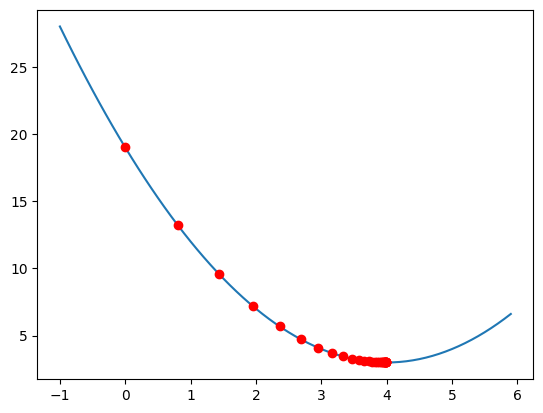

In [20]:
def f(x):
    return x**2 - 8*x + 19

x= torch.arange(-1, 6, 0.1)
y = f(x)
plt.plot(x, y)

x = torch.tensor(0.0, requires_grad=True)
optimizer = torch.optim.SGD([x], lr=0.1)

for epoch in range(30):
    optimizer.zero_grad()
    y = f(x)
    plt.plot(x.detach(), y.detach(), "ro")
    y.backward()
    optimizer.step()# X gets updated here!
    #print(x, y)
    
print("\nOptimized value: ", x.item())

In [21]:
#Part 4: Linear Regression

In [22]:
ds = torch.utils.data.TensorDataset(
    trainX_tensor,
    trainY_tensor
)
dl = torch.utils.data.DataLoader(ds, shuffle=True, batch_size=10)

In [23]:
model = torch.nn.Linear(10, 1, dtype = torch.float64)
optimizer = torch.optim.SGD([model.weight, model.bias], lr=0.0000001)
LOSS_fn = torch.nn.MSELoss()
start = time.time()
for epoch in range(300):
    for batchx, batchy in dl:
        predictedy=model(batchx)
        loss=LOSS_fn(batchy, predictedy)
        loss.backward() #update weight.grad and bias.grad
        optimizer.step() # update weight and bias based on the graidents
        optimizer.zero_grad() # weight.grad = 0 and bias.grad = 0
    x, y = ds[:]
    #HOW AM I DOING SO FAR?
    # if(epoch%10==0):
    #     print(epoch, LOSS_fn(y, model(x)))
end = time.time()
print("\nTraining time: ", end-start)
predictedY = testX_tensor @ model.weight.reshape(10,-1)
print("R^2 score: ", r2_score(testY_tensor, predictedY).item())


Training time:  10.424732446670532
R^2 score:  0.57599758551747


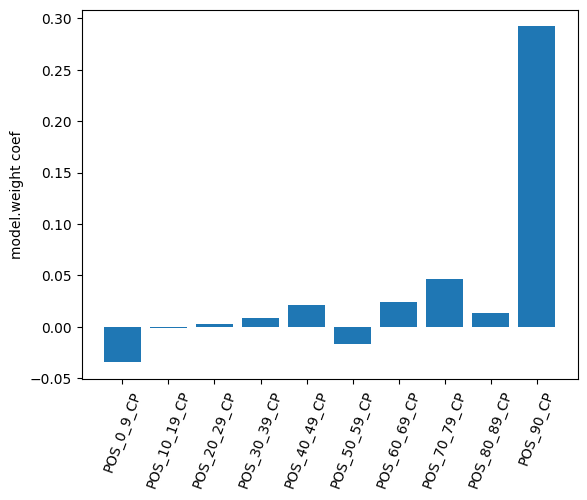

In [27]:
fig = plt.bar(range(len(model.weight.detach()[0])), model.weight.detach()[0], tick_label=train_df.columns.values[:-1])
fig = plt.xticks(rotation=70)
fig = plt.ylabel("model.weight coef")
plt.show()